In [1]:
#!pip install conda

In [2]:
#!conda install basemap-data-hires

In [3]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm

import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [6]:
# Population data/ looking for streams per capita
pop_data=pd.read_csv("Postcode districts.csv") #source: https://www.doogal.co.uk/PostcodeDownloads.php
pop_data=pop_data[["Postcode","Population"]]
pop_data['Postcode'] = pop_data['Postcode'].str.replace('\d+', '')
pop_data=pop_data.groupby("Postcode").agg("sum")
pop_data.reset_index(inplace=True)
pop_data.rename(columns = {'Postcode':'area'}, inplace = True)
pop_data.head()

,area,Population
0,AB,499692.0
1,AL,249911.0
2,B,1904293.0
3,BA,434539.0
4,BB,488564.0


In [8]:
data = pd.read_csv('mapdata.csv') #data extracted from main datafile of spotify streams
data=data[data["success_2017"]==0] #THIS IS FOR THE SUCCESFUL
regions=data["region_code"].value_counts().reset_index()

# Import the postcodes and make the columns consistent for merging
code=pd.read_csv("export.csv")  #https://en.wikipedia.org/wiki/ISO_3166-2:GB
code.rename(columns={"Code":"code"},inplace=True)
regions.rename(columns={"index":"code","region_code":"counts"},inplace=True)

#Merge the two dataframes
regions_final=regions.merge(code, on="code", how="left")

In [9]:
regions_final.head()

,code,counts_x,counts_y,Area Name,County type,Country Code,area
0,GB-LND,16806,495661,London,city corporation,ENG,E
1,GB-SRY,1758,76532,Surrey,two-tier county,ENG,GU
2,GB-BIR,1640,105316,Birmingham,metropolitan district,ENG,B
3,GB-MAN,1557,78696,Manchester,metropolitan district,ENG,M
4,GB-GLG,1528,72776,Glasgow City,council area,SCT,G


In [10]:
# If we want to see a map with only the succesful streams by regions we need to activate the comments below

#regions_final.drop("counts_y",inplace=True,axis=1) #THIS IS FOR THE SUCCESFULL
#regions_final.drop("counts_x",inplace=True,axis=1)

#regions_final.rename(columns={"counts_x":"count"},inplace=True) #THIS IS FOR THE SUCCESSFUL
#regions_final.rename(columns={"counts_y":"count"},inplace=True)

df=regions_final.groupby("area").agg("sum").reset_index()

In [11]:
df.head()

,area,counts_x,counts_y
0,AB,684,34933
1,AL,1212,63144
2,B,1887,117980
3,BA,2029,100662
4,BB,545,28398


In [12]:
df=df.merge(pop_data,on="area",how="left")
df.loc[df.area == "EC", 'Population'] = 33205
df["streams_per_capita_unsuccesful"]=(df["counts_x"]/df["Population"])*100
df["streams_per_capita_succesful"]=(df["counts_y"]/df["Population"])*100
df = df.sort_values(by="streams_per_capita_succesful", ascending=False)
df.head()

,area,counts_x,counts_y,Population,streams_per_capita_unsuccesful,streams_per_capita_succesful
29,E,16844,519381,976352.0,1.725197,53.196081
30,EC,41,16758,33205.0,0.123475,50.468303
13,CB,2363,128495,421151.0,0.561081,30.510434
1,AL,1212,63144,249911.0,0.484973,25.266595
3,BA,2029,100662,434539.0,0.466932,23.165239


In [13]:
df["total_succesful"]=df["counts_x"].sum()
df["total_unsuccesful"]=df["counts_y"].sum()
df["total_by_region"]=df["counts_x"]+df["counts_y"]
df["perc_successful"]=(df["counts_x"]/df["total_succesful"])*100
df["perc_unsuccessful"]=(df["counts_y"]/df["total_unsuccesful"])*100

In [14]:
df.sort_values(by="total_by_region",ascending=False)
df=df[["area","counts_x","counts_y","total_by_region"]]
df["perc_succesful"]=df["counts_x"]/df["total_by_region"]
df.head()

,area,counts_x,counts_y,total_by_region,perc_succesful
29,E,16844,519381,536225,0.031412
30,EC,41,16758,16799,0.002441
13,CB,2363,128495,130858,0.018058
1,AL,1212,63144,64356,0.018833
3,BA,2029,100662,102691,0.019758


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


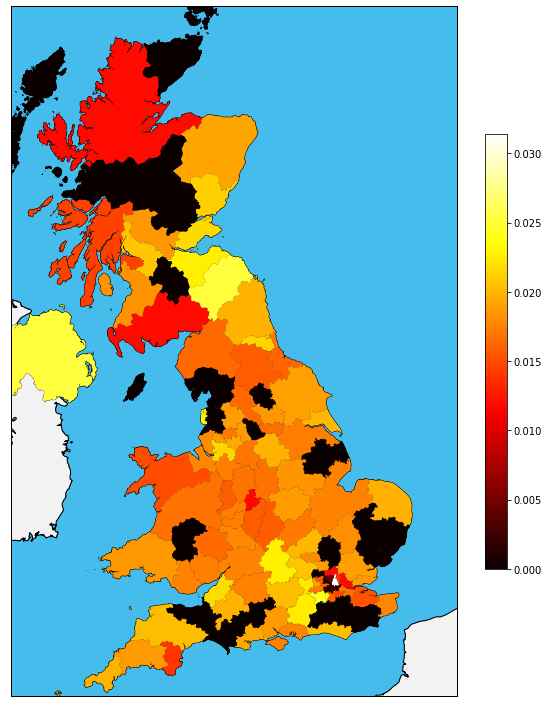

In [16]:
fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-7.4, llcrnrlat= 49.9,urcrnrlon=2.78, urcrnrlat=59.)
             
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('./Areas/Areas', 'areas')

df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'area': [area['name'] for area in m.areas_info]
    })
df_poly = df_poly.merge(df, on='area', how='left')

cmap = plt.get_cmap('hot')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['perc_succesful'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['perc_succesful'])
plt.colorbar(mapper, shrink=0.4)
plt.savefig('map_unsuccess.png', bbox_inches='tight', pad_inches=0.0, quality=95)

In [ ]:
fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-7.4, llcrnrlat= 49.9,urcrnrlon=2.78, urcrnrlat=59.)
             
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('./Areas/Areas', 'areas')

df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'area': [area['name'] for area in m.areas_info]
    })
df_poly = df_poly.merge(df, on='area', how='left')

cmap = plt.get_cmap('inferno_r')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['perc_succesful'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['perc_succesful'])
plt.colorbar(mapper, shrink=0.4)
plt.savefig('map_success.png', bbox_inches='tight', pad_inches=0.0, quality=95)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
